## Objective of the Notebook:

### Main Objective : Given a fluroscopic image - Locate the Guide wire Region - Crop out the region - Predict angle and centre offset - Compare results with Ground Truth


#### Milestones:

1. Load the test data images and preprocess
2. Run FasterRCNN model and get results - crop each resultant predicted image and use it as input for Resnet50 predict angle and pos model
3. For each bounding box - get the angle and pos - Compare with GT - Report Results

In [126]:
# Imports
import pathlib
import numpy as np
from matplotlib import pyplot as plt
from skimage import exposure
from sklearn.model_selection import train_test_split
import torch
import torchvision  # modules and transforms for computer vision
from tqdm.auto import tqdm  # progress bar
import torchvision.models as models
from sklearn.metrics import mean_absolute_error
from torchvision.models.detection import faster_rcnn
import statistics

In [2]:
# Mounting drive - to be used as switch later - local system or drive
colab=False
if colab:
  import google
  google.colab.drive.mount('/content/drive', force_remount=True)
  drive = pathlib.Path('./drive/MyDrive/')

else:
  drive="D:\\Project\\Data\\"

### Milestone 1 - Load Test Data and Preprocess

In [3]:
fdataset = pathlib.Path(drive +'GuidewireDataset.npz')
with np.load(fdataset) as f:
    dataset = dict(f)

In [4]:
# Looping through each image, position and direction - from the dictionary
images = [x.astype(float) for x in dataset['images']] # Making images in floating point dtype
images = [exposure.equalize_hist(x) for x in images] # Performing histogram equalization
images = [np.interp(x, (0,1), (np.min(x),np.max(x))) for x in images] # Making the range from 0 to 1 
images = [1 - x for x in images] # Making the guidewire(target) - to have the higher side of contrast - to boost the network 
positions = [np.transpose(x) for x in dataset['positions']] # Extracting the position - transposing to get x | y in columns than in rows - to plot easily 
directions = [np.transpose(x) for x in dataset['directions']]# Extracting the direction  transposing to get x | y in columns than in rows - to plot easily 

In [5]:
# Generating the dataset - in form of images and target bounding boxes
Generated_images=[]
Targets=[]

number_of_images=len(images)
for id in range(number_of_images):
    i = id  # image index
    w = 50  # window size - half (since left and right)
    target={}
    boxes=[]
    angles=[]
    centers=[]
    for position, direction in zip(positions[i].T, directions[i].T):
      j1, j2 = round(position[1] - w), round(position[1] + w + 1)
      k1, k2 = round(position[0] - w), round(position[0] + w + 1)
      generated_image=images[i]
      angle = np.rad2deg(np.arctan2(*direction))
      if angle < 0:
          angle = 360 + angle
      centre=(position[0],position[1])
      boxes.append([k1, j1, k2, j2])
      angles.append(angle)
      centers.append(centre)
        
    areas = [(xmax - xmin) * (ymax - ymin) for xmin, ymin, xmax, ymax in boxes]
    target['boxes'] = np.array(boxes, dtype=np.float32)
    target['labels'] = np.ones(len(boxes), dtype=np.int64)
    target['image_id'] = np.array([id], dtype=np.int64)
    target['area'] = np.array(areas, dtype=np.float32)
    target['iscrowd'] = np.zeros(len(boxes), dtype=np.int64)
    target['Angle']=np.array(angles, dtype=np.float32)
    target['Centre']=np.array(centers, dtype=np.float32)
    Targets.append(target)
    Generated_images.append(images[i])

In [6]:
print(len(Generated_images))
print(len(Targets))

314
314


In [7]:
check_test=np.load(drive+"Test_Indices.npy")
test_indices=check_test.tolist()

print(test_indices)

[198, 312, 266, 263, 105, 194, 298, 38, 109, 154, 47, 10, 285, 199, 233, 77, 221, 98, 252, 16, 302, 121, 66, 80, 134, 238, 46, 264, 300, 201, 309, 59, 210, 67, 187, 14, 82, 25, 83, 186, 304, 126, 31, 269, 84, 203, 74, 143, 73, 5, 128, 122, 65, 231, 276, 234, 311, 114, 79, 245, 58, 61, 248]


In [8]:
Test_Images=[Generated_images[x] for x in test_indices]
Test_Targets=[Targets[x] for x in test_indices]

In [9]:
print(len(Test_Targets))
print(Test_Targets[0])

63
{'boxes': array([[438., 371., 539., 472.],
       [282., 360., 383., 461.]], dtype=float32), 'labels': array([1, 1], dtype=int64), 'image_id': array([198], dtype=int64), 'area': array([10201., 10201.], dtype=float32), 'iscrowd': array([0, 0], dtype=int64), 'Angle': array([236.93549, 274.3723 ], dtype=float32), 'Centre': array([[488.4623 , 421.24353],
       [331.6851 , 409.5835 ]], dtype=float32)}


In [10]:
# Creating the Dataset in torch form
class Dataset_Guide_wire_Tip(torch.utils.data.Dataset):
    def __init__(self, list_of_images, list_of_targets, transform=None):
        super().__init__()
        self.images=list_of_images
        self.targets=list_of_targets
        self._transform=transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, index):
        image = self.images[index]
        image=np.repeat(image[:, :, np.newaxis], 3, axis=2) # Putting same image three times for three channels
        image = image.transpose([2,0,1])
        image = image.astype(np.float32)
        target=self.targets[index]
        image = torch.as_tensor(image.copy())
        for key, value in target.items():
            if torch.is_tensor(value):
                value=value.numpy()
            target[key] = torch.as_tensor(value.copy())

        if self._transform is not None:
            image, target = self._transform([image, target])
        #print(target)
        return image, target

In [11]:
def collate(batch):
    return tuple(zip(*batch))

In [12]:
loader_test = torch.utils.data.DataLoader(
    dataset=Dataset_Guide_wire_Tip(Test_Images,Test_Targets),
    batch_size=1,
    collate_fn=collate)

### Milestone 2 - Run Faster RCNN model and resnet50 model - Get position and angle

In [13]:
class FastRCNNPredictor(torch.nn.Module):

    def __init__(self, in_features, num_classes):
        super().__init__()
        self.cls_score = torch.nn.Linear(in_features, num_classes)
        self.bbox_pred = torch.nn.Linear(in_features, num_classes * 4)

    def forward(self, x):
        x = x.flatten(start_dim=1)
        scores = self.cls_score(x)
        bbox_deltas = self.bbox_pred(x)
        return scores, bbox_deltas

In [14]:
model=torch.load(drive+"Faster_RCNN_mode.pth")
model2=torch.load(drive+"Predict_angle_centre_offset.pth")
device = torch.device('cuda')

In [15]:
score_threshold = 0.5

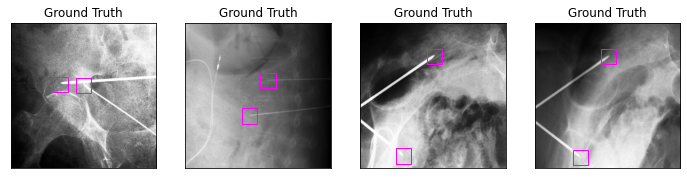

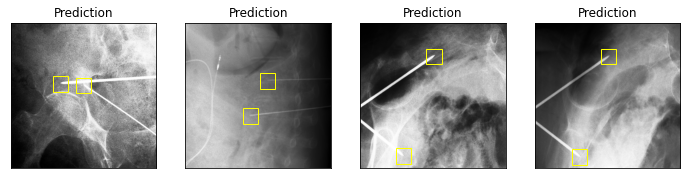

In [16]:
nimages = 4
fig, axs = plt.subplots(ncols=nimages, figsize=(nimages*3,3), subplot_kw={'xticks': [], 'yticks': [],'title':'Ground Truth'})
fig, axs2 = plt.subplots(ncols=nimages, figsize=(nimages*3,3), subplot_kw={'xticks': [], 'yticks': [],'title':'Prediction'})
i = 0
with torch.no_grad():
    model.eval()
    for images, targets in loader_test: 
        if i >= nimages:
            break
        predictions = model([x.to(device) for x in images])
        for image, target, prediction in zip(images, targets, predictions):
            if i >= nimages:
                break
            axs[i].imshow(image.numpy().transpose([1,2,0]))
            axs2[i].imshow(image.numpy().transpose([1,2,0]))
            for xmin, ymin, xmax, ymax in target['boxes'].numpy():
                axs[i].add_patch(plt.Rectangle((xmin, ymin), xmax - xmin + 1, ymax - ymin + 1, ec='magenta', fc='none'))
            for (xmin, ymin, xmax, ymax), score in zip(prediction['boxes'].cpu().numpy(), prediction['scores'].cpu().numpy()):
                if score < score_threshold:
                    continue
                axs2[i].add_patch(plt.Rectangle((xmin, ymin), xmax - xmin + 1, ymax - ymin + 1, ec='yellow', fc='none'))
            i += 1

In [17]:
def intersection_over_union(box_a, box_b):
    xmin = max(box_a[0], box_b[0])
    ymin = max(box_a[1], box_b[1])
    xmax = min(box_a[2], box_b[2])
    ymax = min(box_a[3], box_b[3])
    area_ab = max(0, xmax - xmin + 1) * max(0, ymax - ymin + 1)
    area_a = (box_a[2] - box_a[0] + 1) * (box_a[3] - box_a[1] + 1)
    area_b = (box_b[2] - box_b[0] + 1) * (box_b[3] - box_b[1] + 1)
    return 100 * area_ab / (area_a + area_b - area_ab)

In [110]:
def calculate_euclidean_distance(x1,y1,x2,y2):
    eus=((x2-x1)**2)+((y2-y1)**2)
    eud=eus**(0.5)
    return eud.item()

In [111]:
def predict_plot_and_return_erros(images,targets):
    predictions = model([x.to(device) for x in images])
    unique_boxes=[]
    ED_error=[]
    AE=[]
    fig1, ax1 = plt.subplots(figsize=(3,3))
    fig2, ax2 = plt.subplots(figsize=(3,3))
    fig3, ax3 = plt.subplots(figsize=(3,3))
    for image, target, prediction in zip(images, targets, predictions):
        for box_a,angle,cen in zip(target['boxes'].numpy(),target['Angle'].numpy(),target['Centre'].numpy()):
            iou=[]
            for box_b, score in zip(prediction['boxes'].cpu().numpy(), prediction['scores'].cpu().numpy()):
                if score < score_threshold:
                    continue
                iou.append(intersection_over_union(box_a, box_b))
            
            
            whichbox=np.argmax(iou)
            unique_boxes.append(whichbox)
            boxes=prediction['boxes'].cpu().numpy()
            box=boxes[whichbox]
            k1, j1, k2, j2=box
            if torch.is_tensor(image):
                image2=image.numpy()
                
            ax1.imshow(image2.transpose([1,2,0]),cmap='gray')
            ax1.add_patch(plt.Rectangle((k1, j1), k2 - k1 + 1, j2 - j1 + 1, ec='yellow', fc='none'))
            
            #Angle and pos prediction
            image2=image[0]
            if torch.is_tensor(image2):
                image2=image2.numpy()
            
            j_cen=(j1+j2)/2
            k_cen=(k1+k2)/2
            w=50
            j1, j2 = round(j_cen - w), round(j_cen + w + 1)
            k1, k2 = round(k_cen - w), round(k_cen + w + 1)
            image_for_angle_pred=image2[round(j1):round(j2),round(k1):round(k2)]
            
            #Applying the model
            model2.eval()
            image_for_angle_pred=np.expand_dims(image_for_angle_pred, axis=0)
            image_for_angle_pred=np.expand_dims(image_for_angle_pred, axis=0)
            image_for_angle_pred = image_for_angle_pred.astype(np.float32) 
            image_for_angle_pred = torch.as_tensor(image_for_angle_pred.copy())  # cast NumPy array to Torch tensor
            outputs = model2(image_for_angle_pred.to(device))
            sine_predictions = outputs[:,0].cpu()
            cosine_predictions = outputs[:,1].cpu()
            x_pos_predictions=outputs[:,2].cpu()
            y_pos_predictions=outputs[:,3].cpu()
            predicted_angle = np.rad2deg(np.arctan2(sine_predictions.item(),cosine_predictions.item()))
            if predicted_angle<0:
                predicted_angle+=360
                
                
            if whichbox==0:
                ax2.imshow(image_for_angle_pred[0].numpy().transpose([1,2,0]),cmap='gray')
                print("BOX 1")
                print("Predicted Angle is ",predicted_angle)
                print("Ground Truth angle is ",angle)
                X=x_pos_predictions+k_cen
                print("Predicted X is ",X)
                print("Ground Truth X pos is ",cen[0])
                Y=y_pos_predictions+j_cen
                print("Predicted Y is ",Y)
                print("Ground Truth Y pos is ",cen[1])
                ED_error.append(calculate_euclidean_distance(X,Y,cen[0],cen[1]))
                AE.append(abs(predicted_angle-angle))
                
            
            if whichbox==1:
                ax3.imshow(image_for_angle_pred[0].numpy().transpose([1,2,0]),cmap='gray')
                print("BOX 2")
                print("Predicted Angle is ",predicted_angle)
                print("Ground Truth angle is ",angle)
                X=x_pos_predictions+k_cen
                print("Predicted X is ",X)
                print("Ground Truth X pos is ",cen[0])
                Y=y_pos_predictions+j_cen
                print("Predicted Y is ",Y)
                print("Ground Truth Y pos is ",cen[1])
                ED_error.append(calculate_euclidean_distance(X,Y,cen[0],cen[1]))
                AE.append(abs(predicted_angle-angle))
                       
        Number_of_unique_boxes=len(set(unique_boxes))
    return Number_of_unique_boxes,ED_error,AE

BOX 2
Predicted Angle is  260.39426805531514
Ground Truth angle is  236.93549
Predicted X is  tensor([488.4645])
Ground Truth X pos is  488.4623
Predicted Y is  tensor([421.0087])
Ground Truth Y pos is  421.24353
BOX 1
Predicted Angle is  271.0877759974116
Ground Truth angle is  274.3723
Predicted X is  tensor([336.4254])
Ground Truth X pos is  331.6851
Predicted Y is  tensor([409.0120])
Ground Truth Y pos is  409.5835
BOX 2
Predicted Angle is  269.56495417602395
Ground Truth angle is  276.74313
Predicted X is  tensor([435.1454])
Ground Truth X pos is  430.86133
Predicted Y is  tensor([628.4890])
Ground Truth Y pos is  624.303
BOX 1
Predicted Angle is  267.6068887263333
Ground Truth angle is  271.3877
Predicted X is  tensor([552.1823])
Ground Truth X pos is  552.45825
Predicted Y is  tensor([392.7481])
Ground Truth Y pos is  387.95523
BOX 2
Predicted Angle is  113.37822867364052
Ground Truth angle is  124.53362
Predicted X is  tensor([493.5797])
Ground Truth X pos is  496.10858
Predict

C:\Users\Krish\AppData\Local\Temp\ipykernel_16144\1230954815.py:8: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig3, ax3 = plt.subplots(figsize=(3,3))


Predicted Angle is  88.85907573419234
Ground Truth angle is  84.69879
Predicted X is  tensor([614.5012])
Ground Truth X pos is  618.6207
Predicted Y is  tensor([603.3720])
Ground Truth Y pos is  603.99316
BOX 2
Predicted Angle is  92.49839699535147
Ground Truth angle is  87.80104
Predicted X is  tensor([493.4343])
Ground Truth X pos is  496.4478
Predicted Y is  tensor([385.5289])
Ground Truth Y pos is  384.49747
BOX 2
Predicted Angle is  185.05753266308454
Ground Truth angle is  182.95563
Predicted X is  tensor([357.3261])
Ground Truth X pos is  361.15402
Predicted Y is  tensor([366.4430])
Ground Truth Y pos is  364.51324
BOX 1
Predicted Angle is  352.60155566100667
Ground Truth angle is  0.4500331
Predicted X is  tensor([458.5508])
Ground Truth X pos is  459.5488
Predicted Y is  tensor([569.0717])
Ground Truth Y pos is  566.0669
BOX 1
Predicted Angle is  62.7837316265453
Ground Truth angle is  69.45449
Predicted X is  tensor([526.8348])
Ground Truth X pos is  524.548
Predicted Y is  t

Predicted X is  tensor([508.9177])
Ground Truth X pos is  508.14984
Predicted Y is  tensor([367.3407])
Ground Truth Y pos is  366.43692
BOX 2
Predicted Angle is  344.7391020113925
Ground Truth angle is  332.44003
Predicted X is  tensor([701.7189])
Ground Truth X pos is  698.5367
Predicted Y is  tensor([574.4238])
Ground Truth Y pos is  567.8904
BOX 1
Predicted Angle is  118.38547539714374
Ground Truth angle is  124.60718
Predicted X is  tensor([496.5132])
Ground Truth X pos is  494.69644
Predicted Y is  tensor([227.5570])
Ground Truth Y pos is  224.89124
BOX 2
Predicted Angle is  61.4435446347033
Ground Truth angle is  52.044235
Predicted X is  tensor([298.7750])
Ground Truth X pos is  298.094
Predicted Y is  tensor([899.1761])
Ground Truth Y pos is  898.19525
BOX 2
Predicted Angle is  88.80044809152352
Ground Truth angle is  84.36068
Predicted X is  tensor([644.6624])
Ground Truth X pos is  642.58545
Predicted Y is  tensor([608.3746])
Ground Truth Y pos is  608.0969
BOX 1
Predicted An

BOX 2
Predicted Angle is  62.269773643189836
Ground Truth angle is  59.49849
Predicted X is  tensor([359.3448])
Ground Truth X pos is  353.23383
Predicted Y is  tensor([632.8092])
Ground Truth Y pos is  629.7545
BOX 1
Predicted Angle is  99.69373298370861
Ground Truth angle is  112.64201
Predicted X is  tensor([397.5858])
Ground Truth X pos is  396.90802
Predicted Y is  tensor([490.7906])
Ground Truth Y pos is  490.60538
BOX 2
Predicted Angle is  95.24545911945197
Ground Truth angle is  104.47702
Predicted X is  tensor([410.1544])
Ground Truth X pos is  411.71838
Predicted Y is  tensor([483.9860])
Ground Truth Y pos is  480.91055
BOX 1
Predicted Angle is  100.30304766636422
Ground Truth angle is  110.43923
Predicted X is  tensor([432.6635])
Ground Truth X pos is  432.52182
Predicted Y is  tensor([219.6379])
Ground Truth Y pos is  221.85765
BOX 2
Predicted Angle is  310.6849349739406
Ground Truth angle is  300.53702
Predicted X is  tensor([689.5357])
Ground Truth X pos is  683.57794
Pre

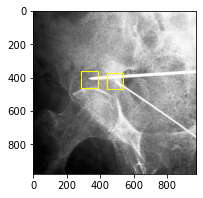

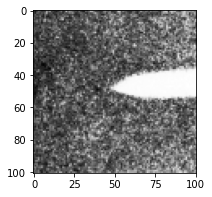

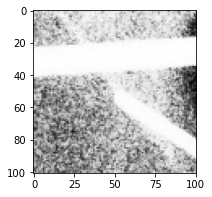

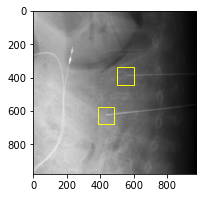

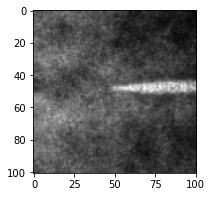

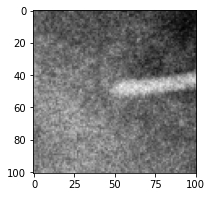

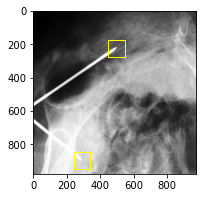

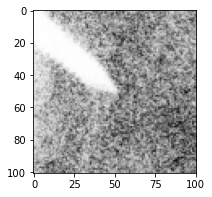

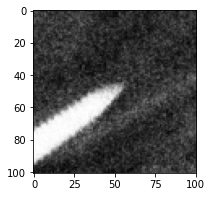

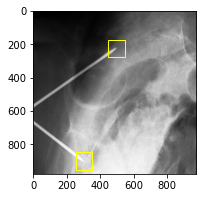

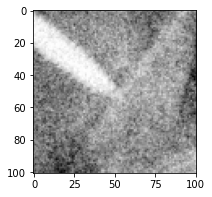

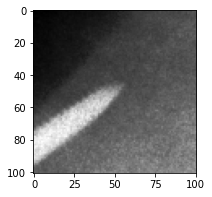

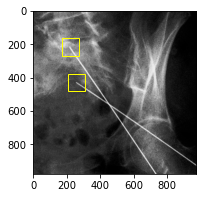

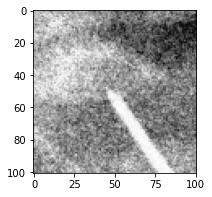

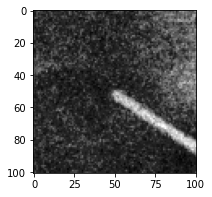

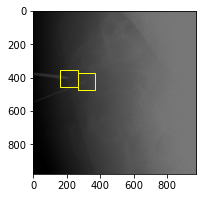

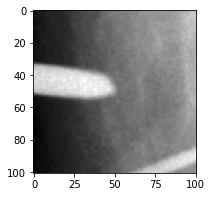

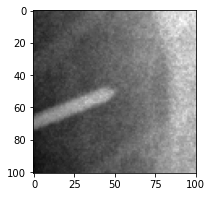

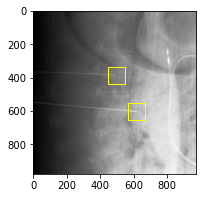

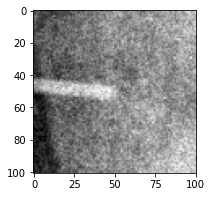

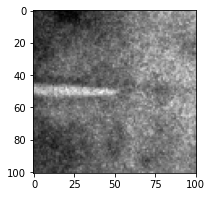

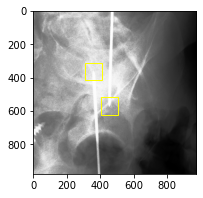

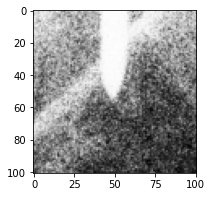

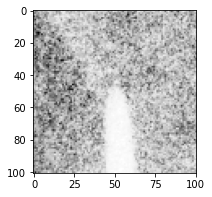

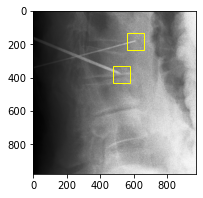

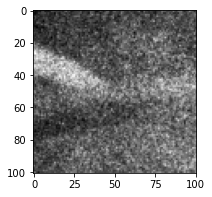

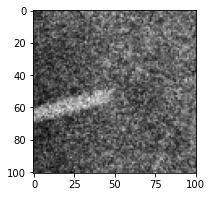

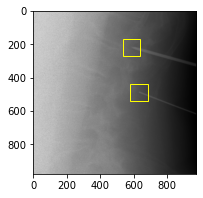

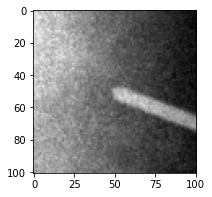

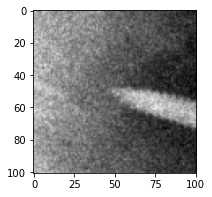

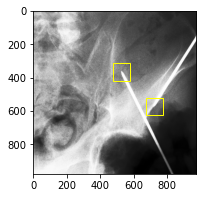

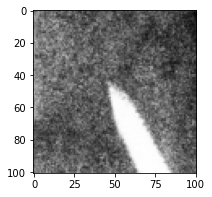

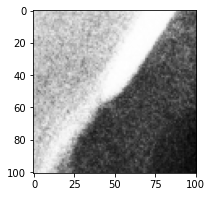

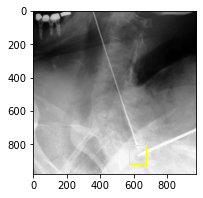

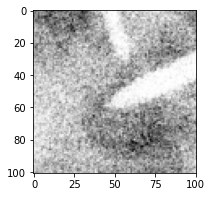

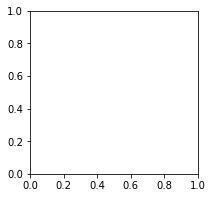

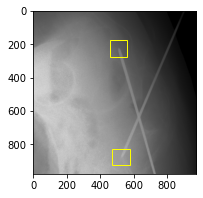

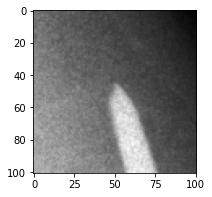

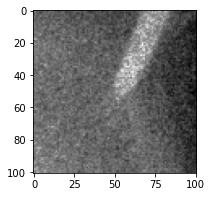

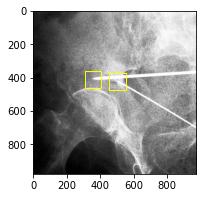

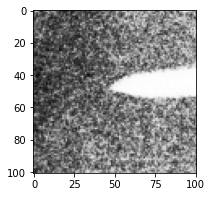

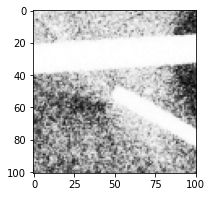

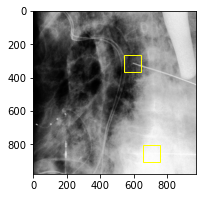

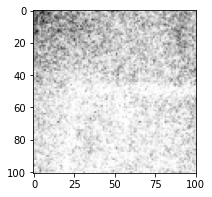

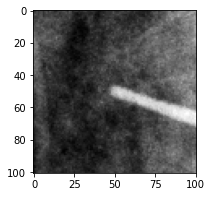

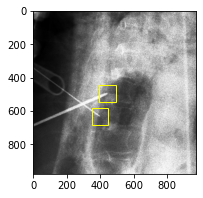

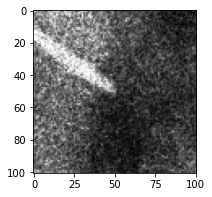

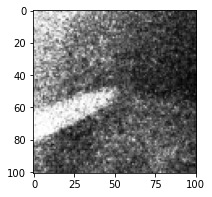

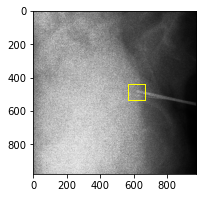

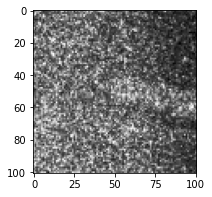

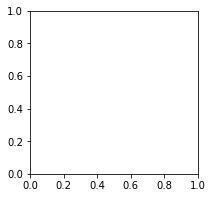

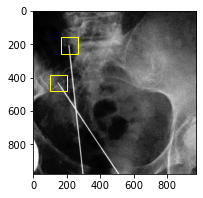

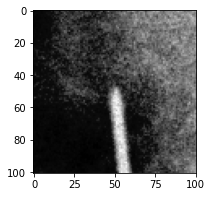

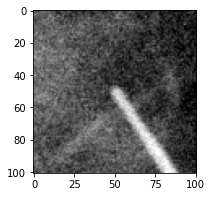

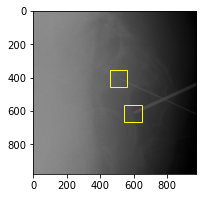

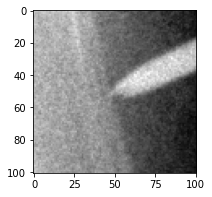

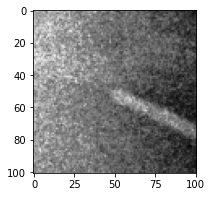

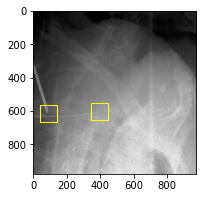

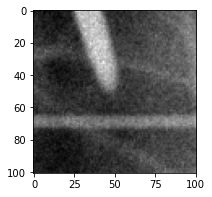

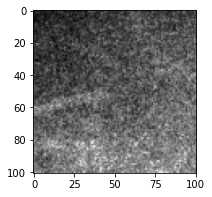

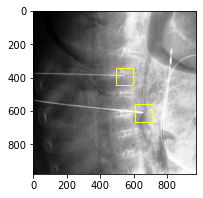

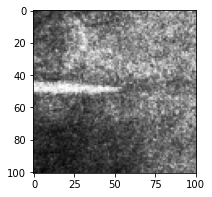

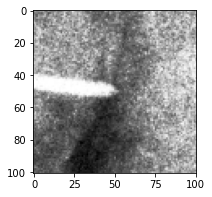

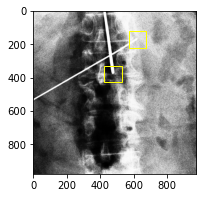

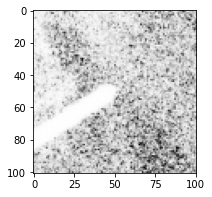

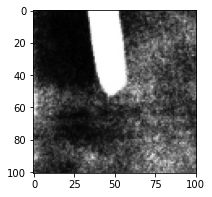

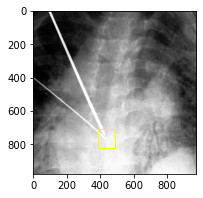

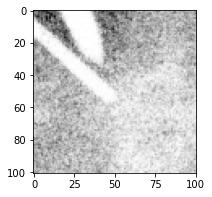

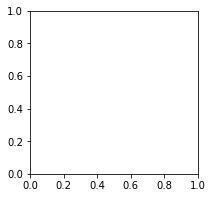

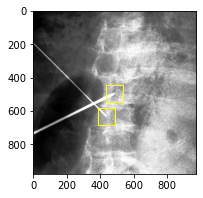

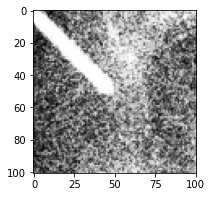

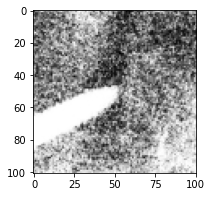

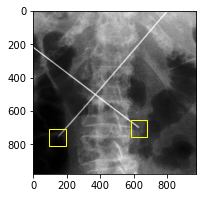

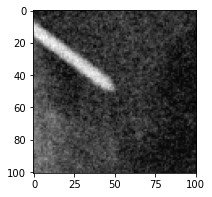

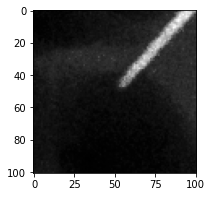

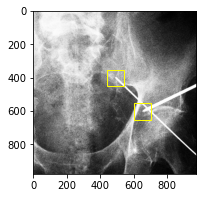

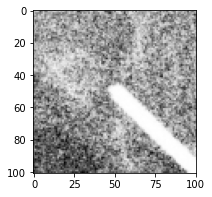

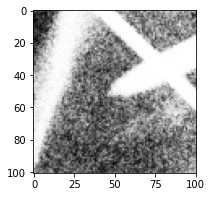

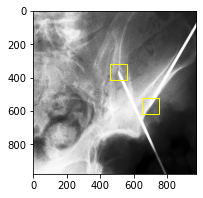

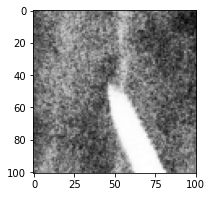

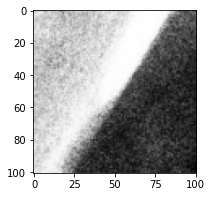

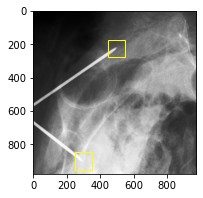

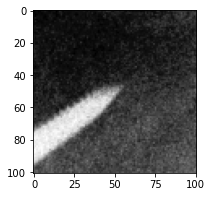

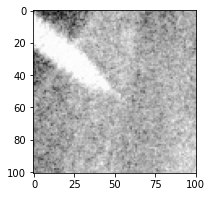

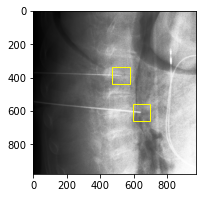

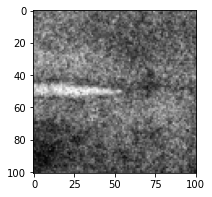

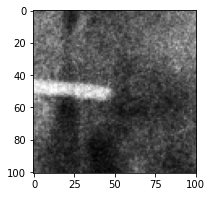

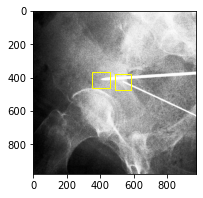

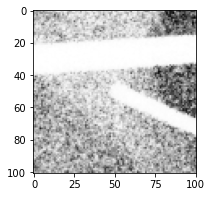

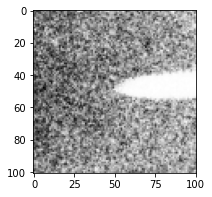

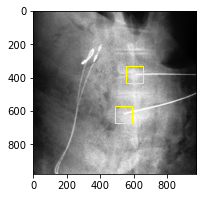

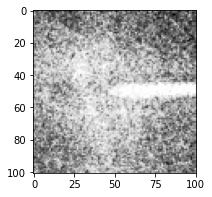

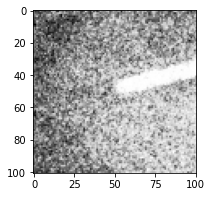

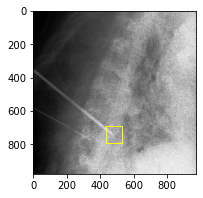

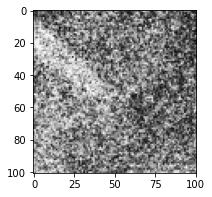

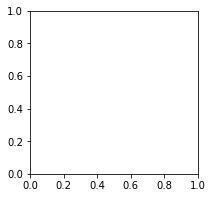

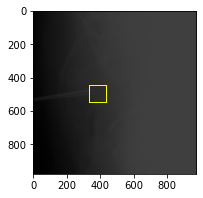

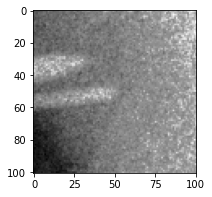

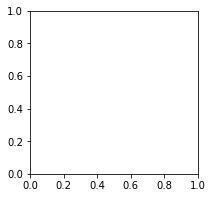

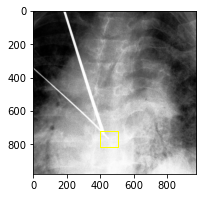

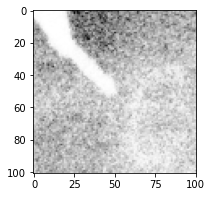

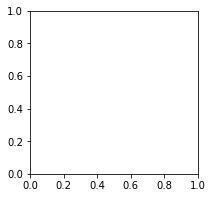

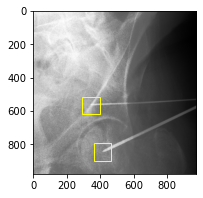

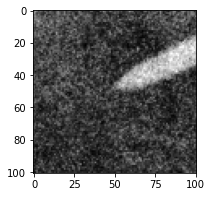

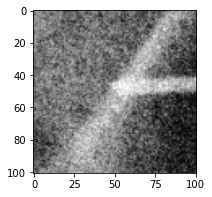

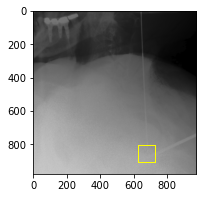

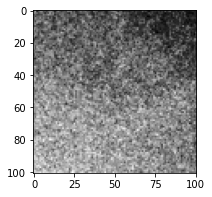

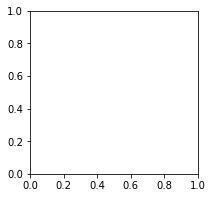

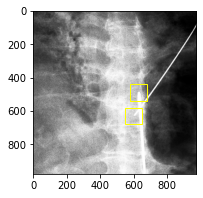

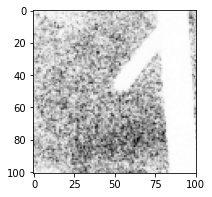

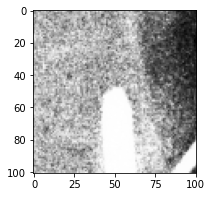

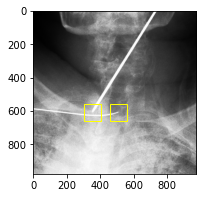

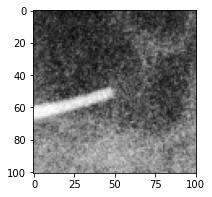

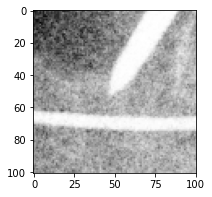

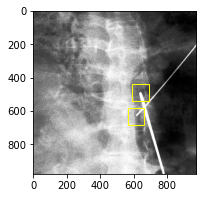

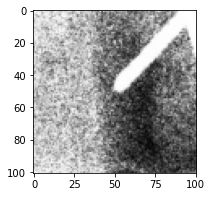

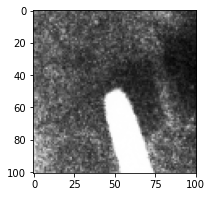

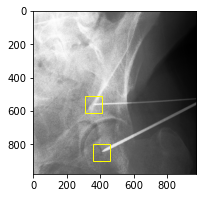

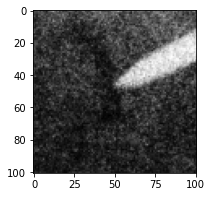

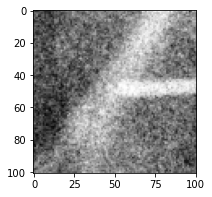

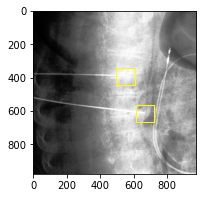

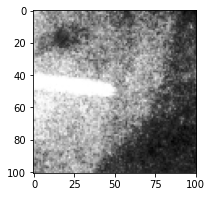

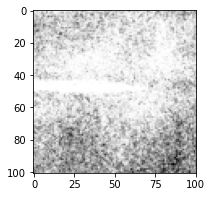

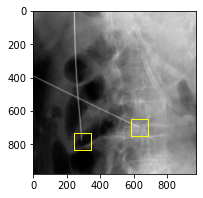

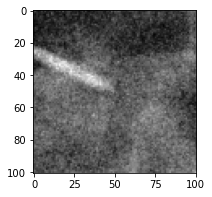

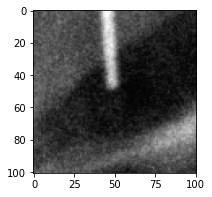

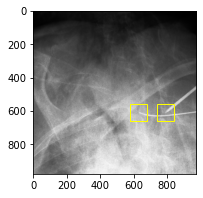

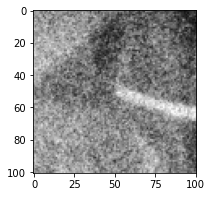

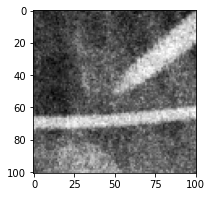

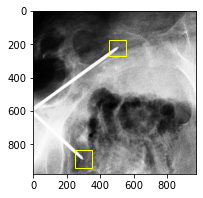

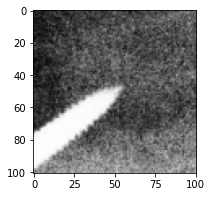

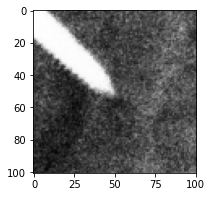

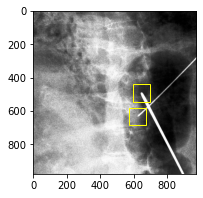

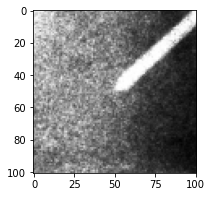

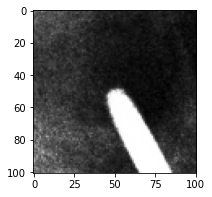

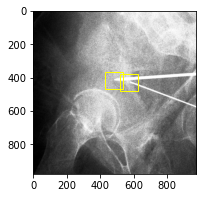

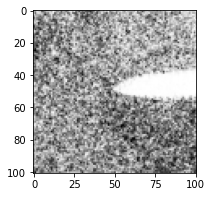

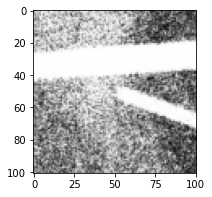

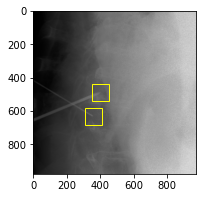

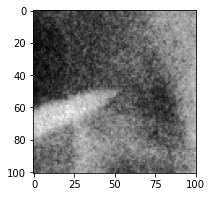

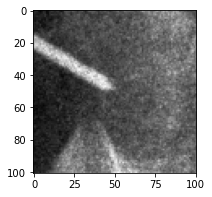

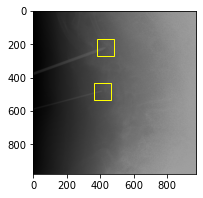

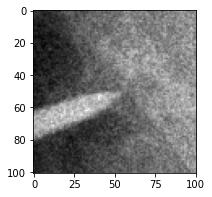

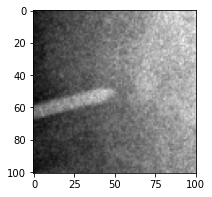

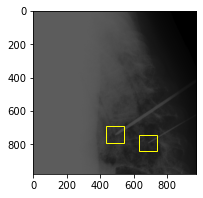

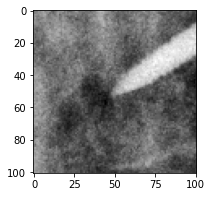

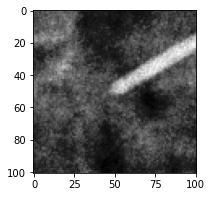

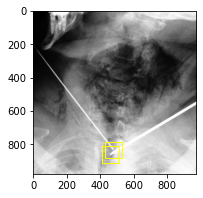

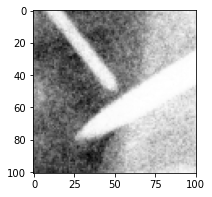

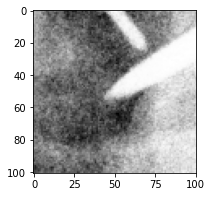

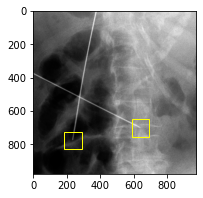

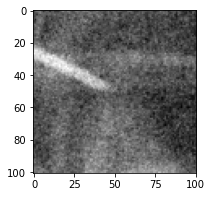

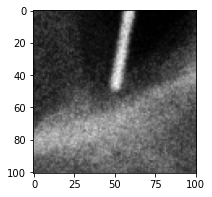

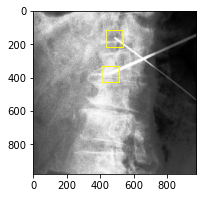

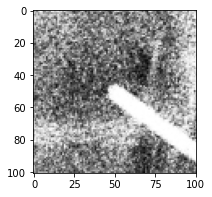

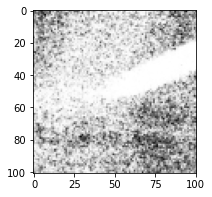

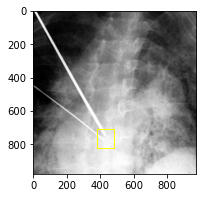

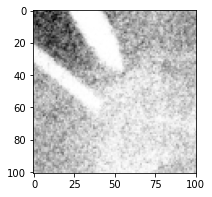

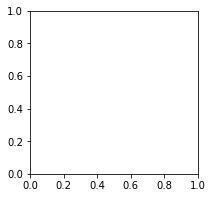

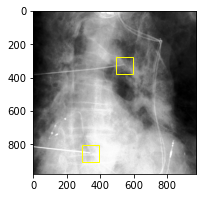

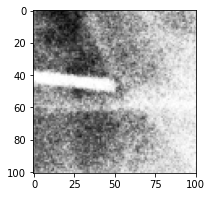

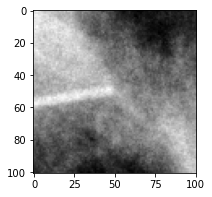

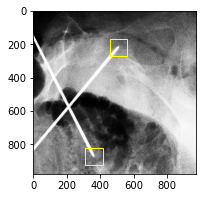

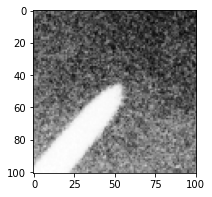

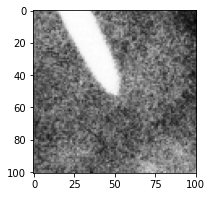

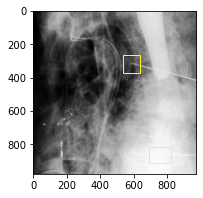

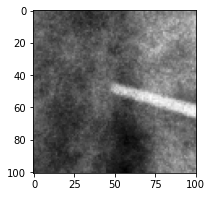

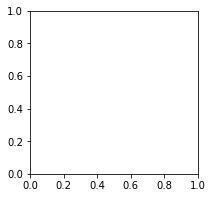

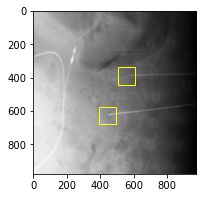

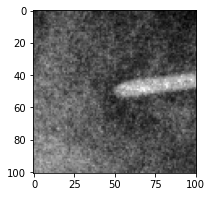

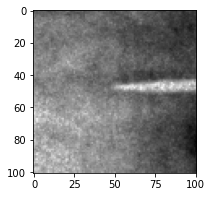

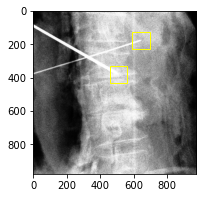

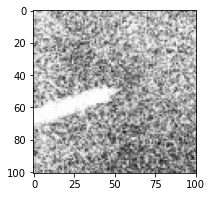

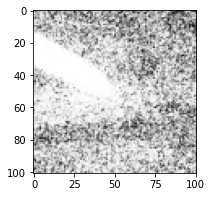

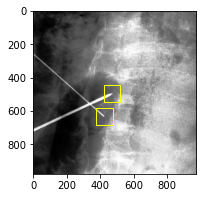

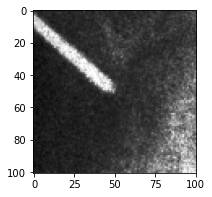

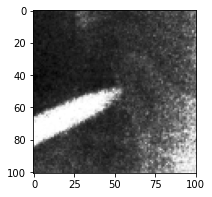

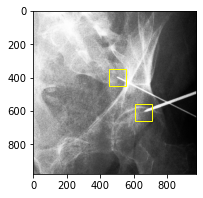

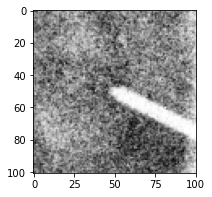

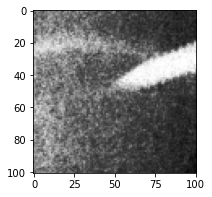

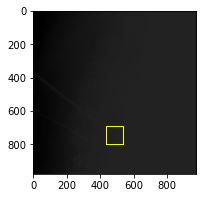

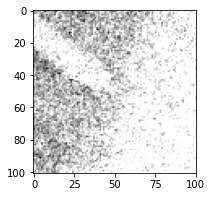

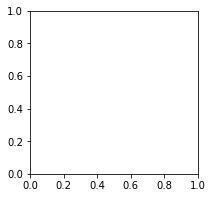

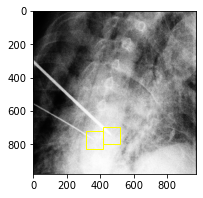

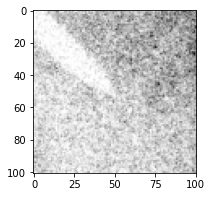

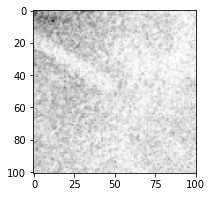

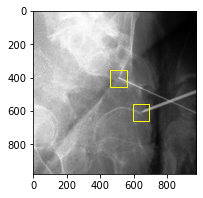

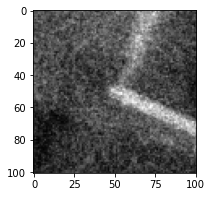

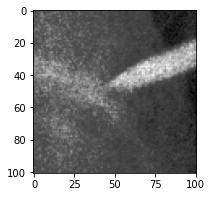

In [113]:
Eucledian_Distance_Errors=[]
Angular_Deviation_Errors=[]
unique_boxes=[]
with torch.no_grad():
    model.eval()
    for images, targets in loader_test:
        N,ED,AE=predict_plot_and_return_erros(images,targets)
        Eucledian_Distance_Errors=Eucledian_Distance_Errors+ED
        Angular_Deviation_Errors=Angular_Deviation_Errors+AE
        unique_boxes.append(N)

### Milestone 3 - Evaluate

In [114]:
print(Eucledian_Distance_Errors)
print(Angular_Deviation_Errors)
print(unique_boxes)

[0.23487356305122375, 4.774679183959961, 5.9896392822265625, 4.800817489624023, 3.271118402481079, 1.7735960483551025, 2.1820225715637207, 6.588876724243164, 4.600653648376465, 4.540313720703125, 3.6158559322357178, 3.9039015769958496, 4.166073799133301, 3.1851744651794434, 4.286848068237305, 3.166168689727783, 2.852647542953491, 3.4495301246643066, 5.9501953125, 2.7160484790802, 3.053588390350342, 8.418452262878418, 15.667167663574219, 11.92320442199707, 2.2959179878234863, 7.029526233673096, 6.251131057739258, 4.4820661544799805, 9.79025650024414, 32.32600021362305, 4.687005043029785, 0.6437197923660278, 11.022017478942871, 50.61473846435547, 4.082233905792236, 2.8254363536834717, 0.5255753993988037, 4.81313943862915, 9.377816200256348, 4.920810699462891, 3.0414297580718994, 3.089747190475464, 3.867300510406494, 2.36780047416687, 6.426114082336426, 20.355403900146484, 0.9890074729919434, 3.288109302520752, 1.077027440071106, 1.254738211631775, 3.96993350982666, 2.194565534591675, 1.1

In [125]:
# Evaluating the Faster RCNN part 
Number_of_GT_Boxes=len(unique_boxes)*2
Number_of_Boxes_Correctly_Found=sum(unique_boxes)
Number_of_Boxes_Wrongly_Predicted=0 #Manually looked through all plots 
Number_of_Boxes_Missed=Number_of_GT_Boxes-Number_of_Boxes_Correctly_Found

# Percentage Calculations
Percentage_of_Boxes_Correctly_Identified=Number_of_Boxes_Correctly_Found/Number_of_GT_Boxes
print("Boxes Correctly Identified ",Number_of_Boxes_Correctly_Found)
print("Boxes Correctly Identified in % ",Percentage_of_Boxes_Correctly_Identified*100)

Percentage_of_Boxes_Wrongly_Identified=0
print("\n\nBoxes Wrongly Identified in ",0)
print("Boxes Wrongly Identified in % ",Percentage_of_Boxes_Wrongly_Identified*100)

Percentage_of_Boxes_Missed=Number_of_Boxes_Missed/Number_of_GT_Boxes
print("\n\nBoxes Missed ",Number_of_Boxes_Missed)
print("Boxes Missed in % ",Percentage_of_Boxes_Missed*100)

Boxes Correctly Identified  117
Boxes Correctly Identified in %  92.85714285714286


Boxes Wrongly Identified in  0
Boxes Wrongly Identified in %  0


Boxes Missed  9
Boxes Missed in %  7.142857142857142


In [128]:
# Evaluating the Eucledian distance Error
Mean_ED_error=sum(Eucledian_Distance_Errors)/len(Eucledian_Distance_Errors)
print("Mean ED error is ",Mean_ED_error)

Median_ED_error=statistics.median(Eucledian_Distance_Errors)
print("Median ED error is ",Median_ED_error)

Mean ED error is  8.531665508508683
Median ED error is  4.419875621795654


In [131]:
# Evaluating the Angle Error - making sure that 358 and 1 are 2 degrees apart and not 357 degrees apart
Angular_Deviation_Errors=[360-er if er>180 else er for er in Angular_Deviation_Errors]

Mean_AE_error=sum(Angular_Deviation_Errors)/len(Angular_Deviation_Errors)
print("Mean AD error is ",Mean_AE_error)

Median_AE_error=statistics.median(Angular_Deviation_Errors)
print("Median AD error is ",Median_AE_error)

Mean AD error is  11.643575575792088
Median AD error is  7.927535298694465
